In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://raw.githubusercontent.com/omicronlab/JAvroPhonetic/json/src/com/omicronlab/avro/phonetic/phonetic.json

--2021-03-15 05:07:17--  https://raw.githubusercontent.com/omicronlab/JAvroPhonetic/json/src/com/omicronlab/avro/phonetic/phonetic.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60654 (59K) [text/plain]
Saving to: ‘phonetic.json.2’

phonetic.json.2     100%[===================>]  59.23K  --.-KB/s    in 0.008s  

2021-03-15 05:07:17 (7.41 MB/s) - ‘phonetic.json.2’ saved [60654/60654]



In [ ]:
!pip install -U scikit-learn
!pip install -U pickle5

     |████████████████████████████████| 22.3MB 2.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 133kB 4.6MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219229 sha256=93d5acdf129553957ddfb0e5e112e28775de721e9b4678f193a2db5a2773a795
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'kamrul1157024' 
os.environ['KAGGLE_KEY'] = '821a18913f0da269df38b9f9609ad422'
!kaggle competitions download -c learn-ai-bbc

BBC%20News%20Train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
BBC%20News%20Test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
BBC%20News%20Sample%20Solution.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/BBC%20News%20Test.csv.zip
!unzip /content/BBC%20News%20Train.csv.zip

Archive:  /content/BBC%20News%20Test.csv.zip
replace BBC News Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  /content/BBC%20News%20Train.csv.zip
replace BBC News Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import numpy as np
import re
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data_english=pd.read_csv('/content/BBC News Train.csv')

In [ ]:
data_english.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [ ]:
data_bangla=pd.read_csv('/content/drive/MyDrive/AI/bangla_text.csv')[:2250]

In [ ]:
data_bangla.head()

,Unnamed: 0,content
0,0,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...
1,1,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...
2,2,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...
3,3,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...
4,4,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...


In [ ]:
print(f'data_english{data_english.shape} | data_bangla{data_bangla.shape}')

data_english(1490, 3) | data_bangla(2250, 2)


In [ ]:
data_bangla=data_bangla.dropna()
data_bangla['content'].isnull().any()
data_bangla['total_words'] = data_bangla['content'].apply(lambda text:len(word_tokenize(text)))
data_english['total_words'] = data_english['Text'].apply(lambda text:len(word_tokenize(text)))
total_bangla_words= data_bangla['total_words'].sum()
total_english_words= data_english['total_words'].sum()
print(f'Bangla Words {total_bangla_words} | English Words {total_english_words}')

Bangla Words 605970 | English Words 605960


In [ ]:
import json
phoneticJson=''
with open('/content/phonetic.json','r',encoding='utf-8') as f:
  phoneticJson=json.load(f)


In [ ]:
inversePhoneticMap={}
for pattern in phoneticJson['patterns']:
  if pattern['replace'] not in inversePhoneticMap.keys():
    inversePhoneticMap[pattern['replace']]=pattern['find']

  for rules in pattern['rules']:
    if rules['replace'] not in inversePhoneticMap.keys():
      inversePhoneticMap[rules['replace']]=pattern['find']

In [ ]:
inversePhoneticMapList={}
for pattern in phoneticJson['patterns']:
  if pattern['replace'] not in inversePhoneticMapList: 
    inversePhoneticMapList[pattern['replace']]=[]
  inversePhoneticMapList[pattern['replace']].append(pattern['find'])
  for rules in pattern['rules']:
    if rules['replace'] not in inversePhoneticMapList: 
      inversePhoneticMapList[rules['replace']]=[]
    inversePhoneticMapList[rules['replace']].append(pattern['find'])

অনেক গুলা রিপ্লেসমেন্ট থাকলে ছোট টা নিচ্ছি কারন মানুষ বেশির ভাগ সময় ছোট টাই টাইপ করে 

In [ ]:
for key in inversePhoneticMapList.keys():
  if len(inversePhoneticMapList[key])>=2:
    inversePhoneticMapList[key].sort(key=lambda key: key.upper())
    print(inversePhoneticMapList[key])
    inversePhoneticMap[key]=inversePhoneticMapList[key][0]


['bhl', 'vl']
['bh', 'v']
['dbh', 'dv']
['ghn', 'Ghn']
['gdh', 'Gdh']
['gN', 'GN']
['gn', 'Gn']
['gm', 'Gm']
['gl', 'Gl']
['gg', 'GG', 'Gg', 'gG', 'jNG']
['gh', 'Gh']
['g', 'G']
['j', 'J']
['kkhN', 'kShN', 'kxN']
['kkhm', 'kShm', 'kxm']
['kkh', 'kSh', 'kx']
['ks', 'x']
['k', 'q']
['lbh', 'lv']
['mf', 'mph']
['mbh', 'mv']
['Ngkkh', 'NgkSh', 'Ngkx']
['nch', 'NGch']
['Nggh', 'ngh']
['Ngkh', 'nkh']
['NGjh', 'njh']
['nc', 'NGc']
['Ngk', 'nk']
['Ngg', 'ngo']
['NGj', 'nj']
['OI', 'OI`']
['OU', 'OU`']
['O', 'O`']
['OI', 'OI']
['OU', 'OU']
['O', 'O', 'o', 'w']
['fl', 'phl']
['f', 'ph']
['rri', 'rri`']
['rri', 'rri']
['rry', 'rrZ']
['ry', 'rZ']
['ry', 'rZ']
['Sch', 'shch']
['Shf', 'Shph']
['sf', 'sph']
['Sc', 'Sc', 'shc']
['sht', 'St']
['shn', 'Sn']
['shm', 'Sm']
['shl', 'Sl']
['S', 'sh']
['oo', 'oo`', 'u', 'u`']
['oo', 'oo', 'u', 'u']
['o', 'o`', '`']
['o', 'o']
['aZ', 'AZ']
['a', 'a`', 'A`']
['a', 'a']
['i', 'i`']
['i', 'i']
['ee', 'ee`', 'I', 'I`']
['ee', 'ee', 'I', 'I']
['U', 'U`']
['U', 'U'

In [ ]:
assert 'a'==inversePhoneticMap['আ']

In [ ]:
def inversePhonetic(text):
  curr_cursor=0
  phonetic=''
  while curr_cursor<len(text):
    matched=False
    for seg_len in range(5,0,-1):
      seg=text[curr_cursor:curr_cursor+seg_len]
      if seg in inversePhoneticMap.keys():
        phonetic=phonetic+ inversePhoneticMap[seg]
        curr_cursor=curr_cursor+seg_len
        matched=True
        break
    if not matched:
      phonetic=phonetic+text[curr_cursor] 
      curr_cursor=curr_cursor+1;
  return phonetic

In [ ]:
inversePhonetic("আমার ভাইয়ের রক্তে রাঙ্গানো ২১ শে ফেব্রুয়ারি আমি কি তোমায় ভূলিতে পারি")

'amar bhayer rkte ranganO 21 Se febrooz়ari ami ki tOmay bhUlite pari'

In [ ]:
!wget https://raw.githubusercontent.com/OpenBangla/riti/master/data/autocorrect.json

--2021-03-15 05:07:43--  https://raw.githubusercontent.com/OpenBangla/riti/master/data/autocorrect.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51407 (50K) [text/plain]
Saving to: ‘autocorrect.json.1’

autocorrect.json.1  100%[===================>]  50.20K  --.-KB/s    in 0.007s  

2021-03-15 05:07:43 (6.96 MB/s) - ‘autocorrect.json.1’ saved [51407/51407]



In [ ]:
autoCorrectJson=''
with open('/content/autocorrect.json','r',encoding='utf-8') as f:
  autoCorrectJson= json.load(f)

In [ ]:
reverseAutoCorrectMap={}
for key in autoCorrectJson.keys():
  reverseAutoCorrectMap[autoCorrectJson[key]]=key

In [ ]:
assert 'add'==reverseAutoCorrectMap['oZaD']

In [ ]:
def reverseAutoCorrect(text):
  text=text+' '
  word=''
  reverseAutoCorrected=''
  for i in range(len(text)):
    if not str.isalpha(text[i]):
      matches=None
      len_matches=0
      for sub_len in range(len(word)):
        if word[:sub_len] in reverseAutoCorrectMap.keys():
          matches=word[:sub_len]
          len_matches=sub_len
        
      if not matches == None:
        reverseAutoCorrected+= reverseAutoCorrectMap[matches]
        
        if not word==matches:
          reverseAutoCorrected+=word[len_matches:]

      else :
        reverseAutoCorrected+= word
      reverseAutoCorrected+=text[i]
      word=''
    else :
      word+=text[i]
  return  reverseAutoCorrected.lower()

In [ ]:
reverseAutoCorrect('amar bhayer rkte ranganO 21 Se febrooz়ari ami ki tOmaY bhUlite pari')

'amar bhayer rkte rangano 21 se febrooz়ari ami ki tomay bhulite pari '

In [ ]:
def reverseBangla(text):
  return reverseAutoCorrect(inversePhonetic(text))

In [ ]:
reverseBangla("আইফোনের অনেক দাম ")

'iphoneer onek dam  '

In [ ]:
reverseBangla("ষ্টিয়ার ভেড়ামারায় জাতীয় জরুরি সেবা নম্বর ৯৯৯-এ ফোন করে পুলিশের সহযোগিতা চাওয়ার পর সন্ত্রাসীদের হামলার শিকার যুবক মামলা করেছেন। সন্ত্রাসীদের কাছে তথ্য জানিয়ে দেওয়ার অভিযোগে ভেড়ামারা থানার কুচিয়ামোড়া পুলিশ ক্যাম্পের উপপরিদর্শক (এসআই) জাহাঙ্গীর হোসেনকে প্রত্যাহার করে পুলিশ লাইনে সংযুক্ত করা হয়েছে।গত শুক্রবার সকালে ভেড়ামারা উপজেলার জুনিয়াদহ ইউনিয়নের ফয়জুল্লাপুর গ্রামে আসাদুল হক (২৮) নামের এক যুবকের ওপর হামলা চালিয়ে জখম করা হয়। আসাদুলের অভিযোগ, শুক্রবার সকাল নয়টার দিকে জুনিয়াদহ এলাকায় তাঁর বাড়ির পাশে পদ্মা নদীতে হঠাৎ তিনটি গুলির শব্দ শুনতে পান। এরপর তিনি দ্রুত জাতীয় জরুরি সেবা ৯৯৯-এ ফোন দিয়ে বিষয়টি জানান। তবে এ ঘটনায় ব্যবস্থা না নিয়ে কুচিয়ামোড়া পুলিশ ক্যাম্পের এসআই অভিযোগ করার তথ্য সন্ত্রাসীদের জানিয়ে দেন। পরে সন্ত্রাসীরা হামলা চালিয়ে আসাদুলকে কুপিয়ে জখম করে।")

'shtiar bheramaray jateey jroori seba nmbr 999-e fon kre pooliser shzogita cawar pr sntraseeder hamlar sikar zoobk mamla krechen. sntraseeder kache tthy janiye dewar obhizoge bheramara thanar koociamora poolis kyamper ooppridrrsk (esai) jahangir hosenke prtyahar kre poolis linee sngzookt kra hyeche.gt sookrbar skale bheramara oopjelar jooniadh iooniyner fyjoollapoor grame asadool hk (28) namer ek zoobker &pr hamla caliye jkhm kra hy. asadooler obhizog, sookrbar skal nytar dike jooniadh elakay ta^r barir pase pdma ndeete hthat`` tinti goolir sbd soonte pan. erpr tini droot jateey jroori seba 999-e fon diye bishyti janan. tbe e ghtnay bybstha na niye koociamora poolis kyamper esai obhizog krar tthy sntraseeder janiye den. pre sntraseera hamla caliye asadoolke koopiye jkhm kre. '

In [ ]:
data_bangla.head(10)

,Unnamed: 0,content,total_words
0,0,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...,272
1,1,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...,168
2,2,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...,359
3,3,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...,1025
4,4,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...,118
5,5,গুগলের মোবাইল অপারেটিং সিস্টেম অ্যান্ড্রয়েডের...,120
6,6,যুক্তরাষ্ট্রের বাজারে জিএসপি-সুবিধা বন্ধ হওয়া...,224
7,7,১১টি বিমা কোম্পানিকে লাইসেন্সের অনুমোদন দিয়েছ...,84
8,8,ম্যাজিস্ট্রেটের মাধ্যমে সিলেটে সিএনজি স্টেশনের...,87
9,9,একক-মিশ্র অ্যালবামে অনেক গানই করেছেন বাপ্পা মজ...,380


Features of the data

In [ ]:
data_bangla['phonetic'] = data_bangla['content'].apply(lambda text : reverseBangla(text))

In [ ]:
data_bangla.head(10)

,Unnamed: 0,content,total_words,phonetic
0,0,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...,272,gajeepoorer kaliz়akoir oopjelar telircala ela...
1,1,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...,168,ebarer ooimbldnta smrneez় kre rakhar misnei j...
2,2,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...,359,jateez় sngsde bienpi cez়arparsn o birodheedl...
3,3,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...,1025,shj pasoz়arrder karne onlain azkaoont shjei h...
4,4,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...,118,kmpiootar maooser oodbhabk dglas azngelbarrt 2...
5,5,গুগলের মোবাইল অপারেটিং সিস্টেম অ্যান্ড্রয়েডের...,120,googler mobail opareting sistem azndrz়eder bd...
6,6,যুক্তরাষ্ট্রের বাজারে জিএসপি-সুবিধা বন্ধ হওয়া...,224,zooktrashtrer buzzare jiespi-soobidha bndh hoz...
7,7,১১টি বিমা কোম্পানিকে লাইসেন্সের অনুমোদন দিয়েছ...,84,11ti bima kompanike laisenser onoomodn diz়ech...
8,8,ম্যাজিস্ট্রেটের মাধ্যমে সিলেটে সিএনজি স্টেশনের...,87,magistrateer madhyme silete sienji stesner ek ...
9,9,একক-মিশ্র অ্যালবামে অনেক গানই করেছেন বাপ্পা মজ...,380,ekk-misr azlbame onek gani krechen bappa mjoom...


In [ ]:
data_bangla['total_phonetic_words']=data_bangla['phonetic'].apply(lambda text: len(word_tokenize(text)))

In [ ]:
total_banglish_words=data_bangla['total_phonetic_words'].sum()

Text(0, 0.5, 'Total Words')

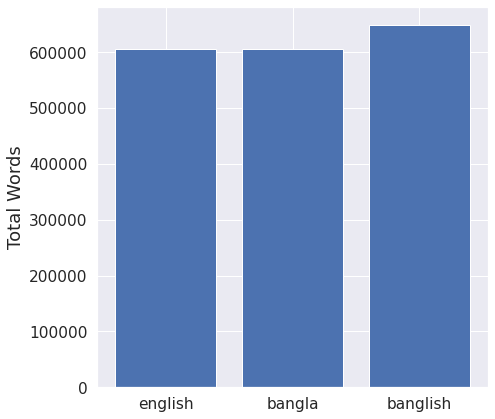

In [ ]:
map={'english':total_english_words,'bangla':total_bangla_words,'banglish':total_banglish_words}
plt.figure(figsize=(7,7))
plt.bar(map.keys(),map.values())
plt.ylabel("Total Words",fontsize=18)

In [ ]:
data=pd.DataFrame(columns=['text','lang'])

In [ ]:
data.head()

,text,lang


In [ ]:
texts=[]
langs=[]

for text in data_bangla.content:
  texts.append(text)
  langs.append('bangla')

for text in data_english.Text:
  texts.append(text)
  langs.append('english')

for text in data_bangla.phonetic:
  texts.append(text)
  langs.append('banglish')


data=pd.DataFrame({'text':texts,'lang':langs}).head(-1)

In [ ]:
data.head(10)

,text,lang
0,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...,bangla
1,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...,bangla
2,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...,bangla
3,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...,bangla
4,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...,bangla
5,গুগলের মোবাইল অপারেটিং সিস্টেম অ্যান্ড্রয়েডের...,bangla
6,যুক্তরাষ্ট্রের বাজারে জিএসপি-সুবিধা বন্ধ হওয়া...,bangla
7,১১টি বিমা কোম্পানিকে লাইসেন্সের অনুমোদন দিয়েছ...,bangla
8,ম্যাজিস্ট্রেটের মাধ্যমে সিলেটে সিএনজি স্টেশনের...,bangla
9,একক-মিশ্র অ্যালবামে অনেক গানই করেছেন বাপ্পা মজ...,bangla


In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
data.head(10)

,text,lang
0,bomb threat at bernabeu stadium spectators wer...,english
1,wilkinson to miss ireland match england will h...,english
2,kksbajarer ckriz়a oopjelar saharbil iooniz়ne...,banglish
3,"‘অর্ডার দেওয়ার দু-তিন ঘণ্টার মধ্যে বাসাবাড়ি,...",bangla
4,bienpir sthaz়ee kmitir sdsy modood ahmd blech...,banglish
5,vw considers opening indian plant volkswagen i...,english
6,উইন্ডোজনির্ভর কম্পিউটারের বিক্রিতে মন্দা চলতে ...,bangla
7,কুমিল্লার জেলা রেজিস্ট্রার লুৎফুর রহমানকে আগাম...,bangla
8,tsunami slows sri lanka s growth sri lanka s p...,english
9,naraz়ngngjer rupgngje gtkal brrihsptibar bike...,banglish


Checking For Null Values

In [ ]:
data.isnull().any()

text    False
lang    False
dtype: bool

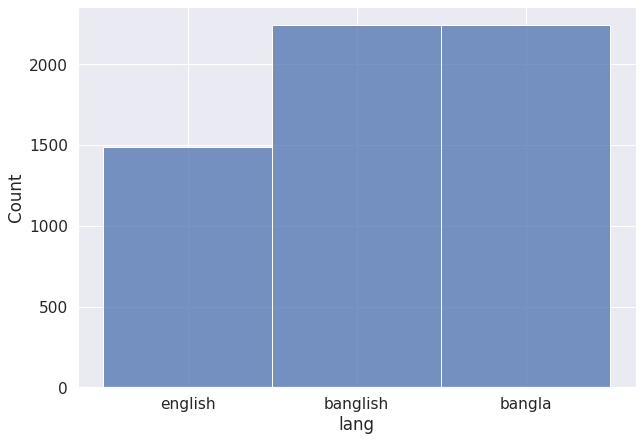

In [ ]:
plt.figure(figsize=(10,7))
sns.histplot(data.lang)

WordCloud to visualize ephasis words

In [ ]:
def process_text(text):
  emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
  begali_digits=re.compile(u'[\u09E6-\u09EF]+',flags=re.UNICODE)
  puntuation=re.compile(u'[.,!?\\-\u0964]',flags=re.UNICODE)
  text=puntuation.sub(r'',text)
  text=begali_digits.sub(r'',text)
  text=emoji_pattern.sub(r'', text)
  text=text.lower().replace('\n',' ').replace('\r','').strip()
  text=re.sub(' +',' ',text)
  text=re.sub('[0-9]*','',text)
  return text

In [ ]:
process_text('I         ৩৫৮৩৫ :P             eAt rice   ,, 8113 1410 কাজ ')

'i :p eat rice   কাজ'

In [ ]:
data['Text_parsed']=data['text'].apply(process_text)

In [ ]:
data.head()

,text,lang,Text_parsed
0,bomb threat at bernabeu stadium spectators wer...,english,bomb threat at bernabeu stadium spectators wer...
1,wilkinson to miss ireland match england will h...,english,wilkinson to miss ireland match england will h...
2,kksbajarer ckriz়a oopjelar saharbil iooniz়ne...,banglish,kksbajarer ckriz়a oopjelar saharbil iooniz়ne...
3,"‘অর্ডার দেওয়ার দু-তিন ঘণ্টার মধ্যে বাসাবাড়ি,...",bangla,‘অর্ডার দেওয়ার দুতিন ঘণ্টার মধ্যে বাসাবাড়ি অ...
4,bienpir sthaz়ee kmitir sdsy modood ahmd blech...,banglish,bienpir sthaz়ee kmitir sdsy modood ahmd blech...


In [ ]:
label_encoder=preprocessing.LabelEncoder()
data['Category_target']=label_encoder.fit_transform(data['lang'])
data.head()

,text,lang,Text_parsed,Category_target
0,bomb threat at bernabeu stadium spectators wer...,english,bomb threat at bernabeu stadium spectators wer...,2
1,wilkinson to miss ireland match england will h...,english,wilkinson to miss ireland match england will h...,2
2,kksbajarer ckriz়a oopjelar saharbil iooniz়ne...,banglish,kksbajarer ckriz়a oopjelar saharbil iooniz়ne...,1
3,"‘অর্ডার দেওয়ার দু-তিন ঘণ্টার মধ্যে বাসাবাড়ি,...",bangla,‘অর্ডার দেওয়ার দুতিন ঘণ্টার মধ্যে বাসাবাড়ি অ...,0
4,bienpir sthaz়ee kmitir sdsy modood ahmd blech...,banglish,bienpir sthaz়ee kmitir sdsy modood ahmd blech...,1


In [ ]:
data.to_csv('Lang_Recognition_Preprorcessing.csv')

Spliting To train and Test Data 

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(data['Text_parsed'],
                                               data['Category_target'],
                                               test_size=.2)

In [ ]:
print(f'Train size: {X_train.shape}')
print(f'Test size: {X_test.shape}')

Train size: (4781,)
Test size: (1196,)


https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

In [ ]:
ngram_range=(1,1)
min_df=10
max_df=1.00
max_features=100

In [ ]:
tfidf=TfidfVectorizer(encoding='utf-8',
                      ngram_range=ngram_range,
                      stop_words=None,
                      lowercase=False,
                      max_df=max_df,
                      min_df=min_df,
                      max_features=max_features,
                      norm='l2',
                      sublinear_tf=True)

In [ ]:
tfidf.fit(X_train)

TfidfVectorizer(lowercase=False, max_features=100, min_df=10, sublinear_tf=True)

In [ ]:
features_train=tfidf.transform(X_train).toarray()
labels_train=Y_train

In [ ]:
features_test=tfidf.transform(X_test).toarray()
labels_test=Y_test

In [ ]:
print(f'Train size: {features_train.shape}')

Train size: (4781, 100)


In [ ]:
pickle.dump(tfidf, open("/content/drive/MyDrive/AI/tfidf_lang_recoginition.pickle", "wb"))

In [ ]:
import time
start_time = time.time()
tf_file = pickle.load(open("/content/drive/MyDrive/AI/tfidf_lang_recoginition.pickle", 'rb'))

tfidf_new=TfidfVectorizer(encoding='utf-8',
                ngram_range=ngram_range,
                stop_words=None,
                lowercase=False,
                max_df=max_df,
                min_df=min_df,
                max_features=max_features,
                norm='l2',
                vocabulary = tf_file.vocabulary_,
                sublinear_tf=True)
print("Execution time %s ms " % ((time.time() - start_time)*1000))

Execution time 29.349327087402344 ms 


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(model,model_predictions):
  model_name = type(model).__name__
  matrix=confusion_matrix(labels_test,model_predictions)
  df_cm = pd.DataFrame(matrix,range(3),range(3) )
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g',cmap='Reds') # font size
  plt.gcf().set_size_inches(3,3)
  plt.title(model_name)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  # TP=matrix[0][0]
  # TN=matrix[1][1]
  # FP=matrix[1][0]
  # FN=matrix[0][1]
  # TN, FP, FN, TP =matrix.ravel()
  # TPR=TP/(TP+FN)
  # TNR=TN/(FP+TN)
  # FPR=FP/(FP+TN)
  # FNR=FN/(TP+FN)
  # format=lambda x:float("{:.2f}".format(x))
  # plt.text(3.5,.5, ("TPR= TP/Total_Postive= "+str(format(TPR))+"       " + "TFR=TN/Total_Negative= "+str(format(TNR))), ha='left', rotation=0, wrap=True)
  # plt.text(3.5,1, ("FPR=FP/Total_Positive= "+str(format(FPR))+"       " + "FNR=FN/Total_Negative= "+str(format(FNR))), ha='left', rotation=0, wrap=True)
  plt.show()


In [ ]:
def executionTime(func):
  import time
  def wrapper(*args,**kwargs):
      start_time = time.time()
      result=func(*args,**kwargs)
      print("Execution time %s ms " % ((time.time() - start_time)*1000))
      return result
  return wrapper

In [ ]:
@executionTime
def executionTimePerformance(model):
  model_name = type(model).__name__
  print(model_name)
  model.predict(features_test)

Random Forest 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_random_forest=RandomForestClassifier()
model_random_forest.fit(features_train,labels_train)
model_random_forest_predictions=model_random_forest.predict(features_test)
print('Accuracy',accuracy_score(labels_test,model_random_forest_predictions))
print(classification_report(labels_test,model_random_forest_predictions))

Accuracy 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       1.00      1.00      1.00       435
           2       1.00      1.00      1.00       308

    accuracy                           1.00      1196
   macro avg       1.00      1.00      1.00      1196
weighted avg       1.00      1.00      1.00      1196



In [ ]:
from sklearn.linear_model import LogisticRegression
model_logistic_regression=LogisticRegression()
model_logistic_regression.fit(features_train,labels_train)
model_logistic_regression_predictions=model_logistic_regression.predict(features_test)
print('Accuracy',accuracy_score(labels_test,model_logistic_regression_predictions))
print(classification_report(labels_test,model_logistic_regression_predictions))

Accuracy 0.9974916387959866
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       453
           1       1.00      1.00      1.00       435
           2       0.99      1.00      1.00       308

    accuracy                           1.00      1196
   macro avg       1.00      1.00      1.00      1196
weighted avg       1.00      1.00      1.00      1196



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_knn=KNeighborsClassifier()
model_knn.fit(features_train,labels_train)
model_knn_predictions=model_knn.predict(features_test)
print('Accuracy',accuracy_score(labels_test,model_knn_predictions))
print(classification_report(labels_test,model_knn_predictions))

Accuracy 0.9966555183946488
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       453
           1       0.99      1.00      1.00       435
           2       1.00      1.00      1.00       308

    accuracy                           1.00      1196
   macro avg       1.00      1.00      1.00      1196
weighted avg       1.00      1.00      1.00      1196



In [ ]:
from sklearn.tree import DecisionTreeClassifier
model_decision_tree=DecisionTreeClassifier()
model_decision_tree.fit(features_train,labels_train)
model_decision_tree_predictions=model_decision_tree.predict(features_test)
print('Accuracy',accuracy_score(labels_test,model_decision_tree_predictions))
print(classification_report(labels_test,model_decision_tree_predictions))

Accuracy 0.995819397993311
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       453
           1       0.99      1.00      0.99       435
           2       1.00      0.99      1.00       308

    accuracy                           1.00      1196
   macro avg       1.00      1.00      1.00      1196
weighted avg       1.00      1.00      1.00      1196



In [ ]:
from sklearn.naive_bayes import GaussianNB
model_gaussian_nb=GaussianNB()
model_gaussian_nb.fit(features_train,labels_train)
model_gaussian_nb_predictions=model_gaussian_nb.predict(features_test)
print('Accuracy',accuracy_score(labels_test,model_gaussian_nb_predictions))
print(classification_report(labels_test,model_gaussian_nb_predictions))

Accuracy 0.9974916387959866
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       1.00      0.99      1.00       435
           2       0.99      1.00      1.00       308

    accuracy                           1.00      1196
   macro avg       1.00      1.00      1.00      1196
weighted avg       1.00      1.00      1.00      1196



In [ ]:
pickle.dump(model_gaussian_nb, open('gaussian_naive_bias.pickle', 'wb'))

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(features_train,labels_train)
model_multinomial_nb_predictions=model_multinomial_nb.predict(features_test)
print('Accuracy',accuracy_score(labels_test,model_multinomial_nb_predictions))
print(classification_report(labels_test,model_multinomial_nb_predictions))

Accuracy 0.9966555183946488
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       453
           1       1.00      1.00      1.00       435
           2       0.99      1.00      0.99       308

    accuracy                           1.00      1196
   macro avg       1.00      1.00      1.00      1196
weighted avg       1.00      1.00      1.00      1196



In [ ]:
pickle.dump(model_multinomial_nb, open('multinomial_naive_bias.pickle', 'wb'))

In [ ]:
from sklearn.svm import SVC
model_svm=SVC(kernel='sigmoid',probability=True)
model_svm.fit(features_train,labels_train)
model_svm_predictions=model_svm.predict(features_test)
print('Accuracy',accuracy_score(labels_test,model_svm_predictions))
print(classification_report(labels_test,model_svm_predictions))

Accuracy 0.9974916387959866
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       453
           1       1.00      1.00      1.00       435
           2       0.99      1.00      1.00       308

    accuracy                           1.00      1196
   macro avg       1.00      1.00      1.00      1196
weighted avg       1.00      1.00      1.00      1196



In [ ]:
pickle.dump(model_svm, open('svm_sigmoid.pickle', 'wb'))

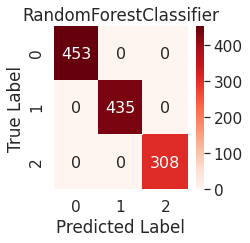

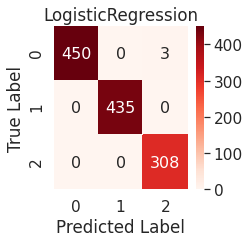

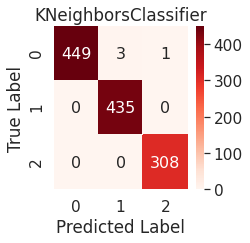

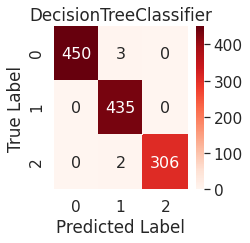

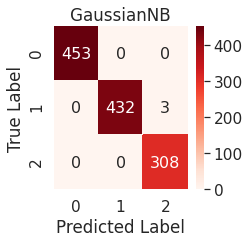

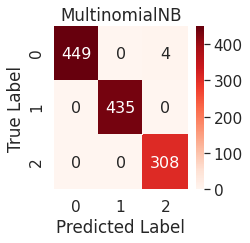

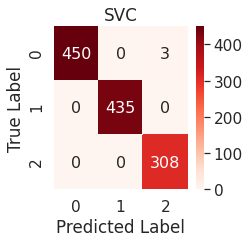

In [ ]:
plot_confusion_matrix(model_random_forest,model_random_forest_predictions)
plot_confusion_matrix(model_logistic_regression,model_logistic_regression_predictions)
plot_confusion_matrix(model_knn,model_knn_predictions)
plot_confusion_matrix(model_decision_tree,model_decision_tree_predictions)
plot_confusion_matrix(model_gaussian_nb,model_gaussian_nb_predictions)
plot_confusion_matrix(model_multinomial_nb,model_multinomial_nb_predictions)
plot_confusion_matrix(model_svm,model_svm_predictions)

In [ ]:
executionTimePerformance(model_random_forest)
executionTimePerformance(model_logistic_regression)
executionTimePerformance(model_knn)
executionTimePerformance(model_decision_tree)
executionTimePerformance(model_gaussian_nb)
executionTimePerformance(model_multinomial_nb)
executionTimePerformance(model_svm)

RandomForestClassifier
Execution time 28.523683547973633 ms 
LogisticRegression
Execution time 0.7739067077636719 ms 
KNeighborsClassifier
Execution time 182.83390998840332 ms 
DecisionTreeClassifier
Execution time 0.7464885711669922 ms 
GaussianNB
Execution time 2.4650096893310547 ms 
MultinomialNB
Execution time 0.6303787231445312 ms 
SVC
Execution time 13.574600219726562 ms 


In [ ]:
import time

In [ ]:
start_time = time.time()
text = "\u09AF\u09BE\u09A8\u09AC\u09BE\u09B9\u09A8 \u099A\u09B2\u09BE\u099A\u09B2\u09C7\u09B0 \u099C\u09A8\u09CD\u09AF \u0986\u0997\u09BE\u09AE\u09C0 \u09AC\u099B\u09B0\u09C7\u09B0 \u09AE\u09BE\u09B0\u09CD\u099A\u09C7 \u09AA\u09A6\u09CD\u09AE\u09BE \u09B8\u09C7\u09A4\u09C1 \u099A\u09BE\u09B2\u09C1 \u0995\u09B0\u09BE\u09B0 \u09AA\u09B0\u09BF\u0995\u09B2\u09CD\u09AA\u09A8\u09BE \u09A8\u09BF\u09DF\u09C7 \u098F\u0997\u09CB\u099A\u09CD\u099B\u09C7 \u09B8\u09B0\u0995\u09BE\u09B0\u0964 \u09B8\u09C7\u09A4\u09C1 \u099A\u09BE\u09B2\u09C1\u09B0 \u09B8\u09AE\u09CD\u09AD\u09BE\u09AC\u09CD\u09AF \u09A6\u09C1\u099F\u09BF \u09A4\u09BE\u09B0\u09BF\u0996 \u09AC\u09BF\u09AC\u09C7\u099A\u09A8\u09BE\u09DF \u0986\u099B\u09C7\u0964 \u098F\u0995\u099F\u09BF \u09B9\u09B2\u09CB \u09E8\u09EC \u09AE\u09BE\u09B0\u09CD\u099A \u09B8\u09CD\u09AC\u09BE\u09A7\u09C0\u09A8\u09A4\u09BE \u09A6\u09BF\u09AC\u09B8\u0964 \u0986\u09B0\u09C7\u0995\u099F\u09BF \u09E7\u09ED \u09AE\u09BE\u09B0\u09CD\u099A \u09AC\u0999\u09CD\u0997\u09AC\u09A8\u09CD\u09A7\u09C1 \u09B6\u09C7\u0996 \u09AE\u09C1\u099C\u09BF\u09AC\u09C1\u09B0 \u09B0\u09B9\u09AE\u09BE\u09A8\u09C7\u09B0 \u099C\u09A8\u09CD\u09AE\u09AC\u09BE\u09B0\u09CD\u09B7\u09BF\u0995\u09C0\u0964 \u09B8\u09C7\u09A4\u09C1 \u09AC\u09BF\u09AD\u09BE\u0997 \u09B8\u09C2\u09A4\u09CD\u09B0\u09C7 \u098F \u09A4\u09A5\u09CD\u09AF \u099C\u09BE\u09A8\u09BE \u0997\u09C7\u099B\u09C7\u0964  \u0997\u09A4 \u09AC\u099B\u09B0\u09C7\u09B0 \u09E7\u09E6 \u09A1\u09BF\u09B8\u09C7\u09AE\u09CD\u09AC\u09B0 \u09B8\u09B0\u09CD\u09AC\u09B6\u09C7\u09B7 \u09B8\u09CD\u09AA\u09CD\u09AF\u09BE\u09A8 \u09AC\u09B8\u09BE\u09A8\u09CB\u09B0 \u09AE\u09A7\u09CD\u09AF \u09A6\u09BF\u09DF\u09C7 \u09EC \u09A6\u09B6\u09AE\u09BF\u0995 \u09E7\u09EB \u0995\u09BF\u09B2\u09CB\u09AE\u09BF\u099F\u09BE\u09B0 \u09A6\u09C0\u09B0\u09CD\u0998 \u09AA\u09A6\u09CD\u09AE\u09BE \u09B8\u09C7\u09A4\u09C1\u09B0 \u09AA\u09C1\u09B0\u09CB\u099F\u09BE \u09A6\u09C3\u09B6\u09CD\u09AF\u09AE\u09BE\u09A8 \u09B9\u09DF\u0964 \u098F\u09B0 \u09AB\u09B2\u09C7 \u09AE\u09C1\u09A8\u09CD\u09B8\u09BF\u0997\u099E\u09CD\u099C\u09C7\u09B0 \u09AE\u09BE\u0993\u09DF\u09BE \u0993 \u09B6\u09B0\u09C0\u09DF\u09A4\u09AA\u09C1\u09B0\u09C7\u09B0 \u099C\u09BE\u099C\u09BF\u09B0\u09BE\u0995\u09C7 \u09AF\u09C1\u0995\u09CD\u09A4 \u0995\u09B0\u09C7\u099B\u09C7 \u09AA\u09A6\u09CD\u09AE\u09BE \u09B8\u09C7\u09A4\u09C1\u0964 \u09B8\u09C7\u09A4\u09C1 \u0995\u09B0\u09CD\u09A4\u09C3\u09AA\u0995\u09CD\u09B7 \u09AC\u09B2\u09C7\u099B\u09C7, \u0997\u09A4 \u09AB\u09C7\u09AC\u09CD\u09B0\u09C1\u09DF\u09BE\u09B0\u09BF \u09AA\u09B0\u09CD\u09AF\u09A8\u09CD\u09A4 \u09B8\u09AC \u09AE\u09BF\u09B2\u09BF\u09DF\u09C7 \u09AA\u09CD\u09B0\u0995\u09B2\u09CD\u09AA\u09C7\u09B0 \u0995\u09BE\u099C\u09C7\u09B0 \u0985\u0997\u09CD\u09B0\u0997\u09A4\u09BF \u09EE\u09EA \u09A6\u09B6\u09AE\u09BF\u0995 \u09EB\u09E6 \u09B6\u09A4\u09BE\u0982\u09B6\u0964 \u098F\u09B0 \u09AE\u09A7\u09CD\u09AF\u09C7 \u09AE\u09C2\u09B2 \u09B8\u09C7\u09A4\u09C1\u09B0 \u0995\u09BE\u099C \u098F\u0997\u09BF\u09DF\u09C7\u099B\u09C7 \u09EF\u09E8 \u09A6\u09B6\u09AE\u09BF\u0995 \u09EB\u09E6 \u09B6\u09A4\u09BE\u0982\u09B6\u0964  \u09B8\u09C7\u09A4\u09C1 \u099A\u09BE\u09B2\u09C1\u09B0 \u09AC\u09BF\u09B7\u09DF\u09C7 \u09B8\u09C7\u09A4\u09C1 \u09AC\u09BF\u09AD\u09BE\u0997\u09C7\u09B0 \u09B8\u099A\u09BF\u09AC \u09AE\u09CB. \u09AC\u09C7\u09B2\u09BE\u09DF\u09C7\u09A4 \u09B9\u09CB\u09B8\u09C7\u09A8 \u0997\u09A4 \u09AC\u09C1\u09A7\u09AC\u09BE\u09B0 \u09AA\u09CD\u09B0\u09A5\u09AE \u0986\u09B2\u09CB\u0995\u09C7 \u09AC\u09B2\u09C7\u09A8, \u2018\u0986\u0997\u09BE\u09AE\u09C0 \u09AC\u099B\u09B0\u09C7\u09B0 \u099C\u09C1\u09A8\u09C7\u09B0 \u09AE\u09A7\u09CD\u09AF\u09C7 \u0995\u09BE\u099C \u09B6\u09C7\u09B7 \u09B9\u09AC\u09C7\u2014\u098F\u099F\u09BE\u0987 \u09B8\u09BF\u09A6\u09CD\u09A7\u09BE\u09A8\u09CD\u09A4\u0964 \u09B8\u09C7 \u0995\u09CD\u09B7\u09C7\u09A4\u09CD\u09B0\u09C7 \u09B8\u09B0\u0995\u09BE\u09B0\u09C7\u09B0 \u09AA\u0995\u09CD\u09B7 \u09A5\u09C7\u0995\u09C7 \u09A4\u09BE\u09B0\u09BF\u0996 \u09A0\u09BF\u0995 \u0995\u09B0\u09BE \u09B9\u09AC\u09C7\u0964 \u09A4\u09AC\u09C7 \u09AE\u09BE\u09B0\u09CD\u099A\u09C7 \u099A\u09BE\u09B2\u09C1\u09B0 \u09AA\u09B0\u09BF\u0995\u09B2\u09CD\u09AA\u09A8\u09BE \u0986\u099B\u09C7\u0964\u2019  \u098F\u09B0 \u0986\u0997\u09C7 \u09AE\u09C2\u09B2 \u09B8\u09C7\u09A4\u09C1\u09B0 \u09A0\u09BF\u0995\u09BE\u09A6\u09BE\u09B0 \u099A\u09BE\u09DF\u09A8\u09BE \u09AE\u09C7\u099C\u09B0 \u09AC\u09CD\u09B0\u09BF\u099C \u0987\u099E\u09CD\u099C\u09BF\u09A8\u09BF\u09DF\u09BE\u09B0\u09BF\u0982 \u0995\u09CB\u09AE\u09CD\u09AA\u09BE\u09A8\u09BF\u09B0 (\u098F\u09AE\u09AC\u09BF\u0987\u09B8\u09BF) \u09B8\u0999\u09CD\u0997\u09C7 \u099A\u09C1\u0995\u09CD\u09A4\u09BF \u0985\u09A8\u09C1\u09B8\u09BE\u09B0\u09C7 \u09AA\u09CD\u09B0\u09A5\u09AE\u09C7 \u09E8\u09E6\u09E7\u09EE \u09B8\u09BE\u09B2\u09C7\u09B0 \u09A1\u09BF\u09B8\u09C7\u09AE\u09CD\u09AC\u09B0\u09C7 \u09B8\u09C7\u09A4\u09C1\u099F\u09BF \u099A\u09BE\u09B2\u09C1\u09B0 \u09B8\u09AE\u09DF\u09B8\u09C0\u09AE\u09BE \u09A0\u09BF\u0995 \u0995\u09B0\u09BE \u09B9\u09DF\u09C7\u099B\u09BF\u09B2\u0964 \u098F\u09B0\u09AA\u09B0 \u09E8\u09E6\u09E7\u09EF, \u09E8\u09E6\u09E8\u09E6 \u0993 \u09E8\u09E6\u09E8\u09E7 \u09B8\u09BE\u09B2\u09C7\u09B0 \u09A1\u09BF\u09B8\u09C7\u09AE\u09CD\u09AC\u09B0\u09C7 \u099A\u09BE\u09B2\u09C1\u09B0 \u0998\u09CB\u09B7\u09A3\u09BE \u09A6\u09C7\u0993\u09DF\u09BE \u09B9\u09DF\u0964 \u09B8\u09B0\u09CD\u09AC\u09B6\u09C7\u09B7 \u09B8\u09B0\u0995\u09BE\u09B0\u09BF \u0998\u09CB\u09B7\u09A3\u09BE\u09DF \u0986\u0997\u09BE\u09AE\u09C0 \u09AC\u099B\u09B0 \u099C\u09C1\u09A8\u09C7\u09B0 \u09AE\u09A7\u09CD\u09AF\u09C7 \u09AA\u09A6\u09CD\u09AE\u09BE \u09B8\u09C7\u09A4\u09C1 \u099A\u09BE\u09B2\u09C1\u09B0 \u0995\u09A5\u09BE \u09AC\u09B2\u09BE \u09B9\u09DF\u09C7\u099B\u09C7\u0964  \u09B8\u09C7\u09A4\u09C1 \u09AC\u09BF\u09AD\u09BE\u0997\u09C7\u09B0 \u0995\u09B0\u09CD\u09AE\u0995\u09B0\u09CD\u09A4\u09BE\u09B0\u09BE \u099C\u09BE\u09A8\u09BE\u09A8, \u09B8\u09B0\u0995\u09BE\u09B0 \u09AC\u09BF\u09AD\u09BF\u09A8\u09CD\u09A8 \u09B8\u09AE\u09DF \u09B8\u09C7\u09A4\u09C1 \u099A\u09BE\u09B2\u09C1\u09B0 \u09A4\u09BE\u09B0\u09BF\u0996 \u0998\u09CB\u09B7\u09A3\u09BE \u0995\u09B0\u09B2\u09C7\u0993 \u09A0\u09BF\u0995\u09BE\u09A6\u09BE\u09B0\u09C7\u09B0 \u09AA\u0995\u09CD\u09B7 \u09A5\u09C7\u0995\u09C7 \u09AC\u09B0\u09BE\u09AC\u09B0\u0987 \u09B8\u09C7\u0987 \u09B8\u09AE\u09CD\u09AD\u09BE\u09AC\u09A8\u09BE \u09A8\u09BE\u0995\u099A \u0995\u09B0\u09BE \u09B9\u09DF\u09C7\u099B\u09C7\u0964 \u0995\u09BE\u09B0\u09A3 \u09B9\u09BF\u09B8\u09C7\u09AC\u09C7 \u09A8\u09A6\u09C0\u09AD\u09BE\u0999\u09A8, \u09B8\u09AE\u09DF\u09AE\u09A4\u09CB \u099C\u09AE\u09BF \u09AC\u09C1\u099D\u09BF\u09DF\u09C7 \u09A8\u09BE \u09A6\u09C7\u0993\u09DF\u09BE, \u09A8\u0995\u09B6\u09BE \u09B8\u0982\u09B6\u09CB\u09A7\u09A8 \u0993 \u0995\u09B0\u09CB\u09A8\u09BE \u09B8\u0982\u0995\u09CD\u09B0\u09AE\u09A3 \u09AA\u09B0\u09BF\u09B8\u09CD\u09A5\u09BF\u09A4\u09BF\u09B8\u09B9 \u09A8\u09BE\u09A8\u09BE \u09B8\u09AE\u09B8\u09CD\u09AF\u09BE\u09B0 \u0995\u09A5\u09BE \u09AC\u09B2\u09C7\u099B\u09C7 \u09A4\u09BE\u09B0\u09BE\u0964 \u09A4\u09AC\u09C7 \u098F\u0996\u09A8 \u09A0\u09BF\u0995\u09BE\u09A6\u09BE\u09B0\u09C7\u09B0 \u09AA\u09CD\u09B0\u09A4\u09BF\u09B6\u09CD\u09B0\u09C1\u09A4\u09BF, \u09B8\u09B0\u0995\u09BE\u09B0\u09C7\u09B0 \u099A\u09BE\u0993\u09DF\u09BE \u0993 \u0995\u09BE\u099C\u09C7\u09B0 \u0985\u0997\u09CD\u09B0\u0997\u09A4\u09BF\u2014\u09B8\u09AC \u0995\u09BE\u099B\u09BE\u0995\u09BE\u099B\u09BF \u098F\u09B8\u09C7 \u09AE\u09BF\u09B6\u09C7\u099B\u09C7\u0964 \u09AB\u09B2\u09C7 \u0986\u0997\u09BE\u09AE\u09C0 \u09AE\u09BE\u09B0\u09CD\u099A\u09C7 \u09B8\u09C7\u09A4\u09C1 \u0996\u09C1\u09B2\u09C7 \u09A6\u09C7\u0993\u09DF\u09BE \u09B8\u09AE\u09CD\u09AD\u09AC \u09B9\u09AC\u09C7 \u09AC\u09B2\u09C7\u0987 \u09A4\u09BE\u09A6\u09C7\u09B0 \u09AC\u09BF\u09B6\u09CD\u09AC\u09BE\u09B8\u0964" #@param {type:"string"}
text=process_text(text)
text_for_pred=tfidf_new.fit_transform([text]).toarray()
model_multinomial_nb_nb_predictions=model_multinomial_nb.predict_proba(text_for_pred)
class_probability=model_multinomial_nb_nb_predictions.flatten()
print(class_probability)

prediction_classes=['bangla','banglish','english']

lang = model_multinomial_nb.predict(text_for_pred)
text=text.replace('\u0964','\u0964 \n')
print(text)
print(prediction_classes[lang[0]])
print("\n")
print("Execution time %s ms " % ((time.time() - start_time)*1000))

[9.99999999e-01 2.45574099e-10 2.72856819e-10]
যানবাহন চলাচলের জন্য আগামী বছরের মার্চে পদ্মা সেতু চালু করার পরিকল্পনা নিয়ে এগোচ্ছে সরকার সেতু চালুর সম্ভাব্য দুটি তারিখ বিবেচনায় আছে একটি হলো মার্চ স্বাধীনতা দিবস আরেকটি মার্চ বঙ্গবন্ধু শেখ মুজিবুর রহমানের জন্মবার্ষিকী সেতু বিভাগ সূত্রে এ তথ্য জানা গেছে গত বছরের ডিসেম্বর সর্বশেষ স্প্যান বসানোর মধ্য দিয়ে দশমিক কিলোমিটার দীর্ঘ পদ্মা সেতুর পুরোটা দৃশ্যমান হয় এর ফলে মুন্সিগঞ্জের মাওয়া ও শরীয়তপুরের জাজিরাকে যুক্ত করেছে পদ্মা সেতু সেতু কর্তৃপক্ষ বলেছে গত ফেব্রুয়ারি পর্যন্ত সব মিলিয়ে প্রকল্পের কাজের অগ্রগতি দশমিক শতাংশ এর মধ্যে মূল সেতুর কাজ এগিয়েছে দশমিক শতাংশ সেতু চালুর বিষয়ে সেতু বিভাগের সচিব মো বেলায়েত হোসেন গত বুধবার প্রথম আলোকে বলেন ‘আগামী বছরের জুনের মধ্যে কাজ শেষ হবে—এটাই সিদ্ধান্ত সে ক্ষেত্রে সরকারের পক্ষ থেকে তারিখ ঠিক করা হবে তবে মার্চে চালুর পরিকল্পনা আছে’ এর আগে মূল সেতুর ঠিকাদার চায়না মেজর ব্রিজ ইঞ্জিনিয়ারিং কোম্পানির (এমবিইসি) সঙ্গে চুক্তি অনুসারে প্রথমে সালের ডিসেম্বরে সেতুটি চালুর সময়সীমা ঠিক করা হয়েছিল এরপর ও সালের ডিসেম্বরে চা

In [ ]:
# from tensorflow.keras.preprocessing.text import one_hot

In [ ]:
# X_test.shape

In [ ]:
# vocbulary_size=10000

In [ ]:
# one_hot_representation=[one_hot(words,vocbulary_size) for words in X_test]
# print(one_hot_representation[0])
# print(one_hot_representation[1])

In [ ]:
# from tensorflow.keras.layers import Embedding
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential

In [ ]:
# sentence_length=50
# embedded_docs = pad_sequences(one_hot_representation,padding='pre',maxlen=sentence_length)
# print(embedded_docs)

In [ ]:
# features_dimentions=20

In [ ]:
# model=Sequential()
# model.add(Embedding(vocbulary_size,features_dimentions,input_length=sentence_length))
# model.compile(optimizer='adam')

In [ ]:
# model.summary()

In [ ]:
# model.predict(embedded_docs)[0].shape

In [ ]:
# def getEmbedding(model,X):
#   one_hot_representation=[one_hot(words,vocbulary_size) for words in X]
#   embedded_docs = pad_sequences(one_hot_representation,padding='pre',maxlen=sentence_length)
#   # model=Sequential()
#   # model.add(Embedding(vocbulary_size,features_dimentions,input_length=sentence_length))
#   # model.compile(optimizer='adam')
#   return model.predict(embedded_docs)


In [ ]:
# X_train_embedded=getEmbedding(model,X_train)
# X_test_embedded=getEmbedding(model,X_test)

In [ ]:
# X_train_embedded.shape

In [ ]:
pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.2
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.1
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.22
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.7
dlib==19.18.0
dm-tree==0.1.5
docopt==0.6.2
docutils=

In [ ]:
!python --version

Python 3.7.10
